<a href="https://colab.research.google.com/github/Kasaligan/Machine-Learning-UNS/blob/main/TP5/Clase_5_crimenes_en_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violent Crime Rates by US State
This data set contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas. The goal of this project is to identify hierarchies of clusters of US states according to violent crime rates data [here](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/USArrests.html). Feel free to augment this data set with other sources. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

violent_crime = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectUSA/data/violent_crime.csv")
violent_crime.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


---
#***ANÁLISIS DEL DATASET***

El dataset presenta los crimenes en los distintos estados de US. El parametro que resulta interesante es:

· "Unnamed: 0": indica a que zona pertenece la fila.

--- 
#***CLUSTERING***

Deseo probar tres tecnicas.

####**Metodo divisivo: K-Means.**
La navaja suiza del clustering, no hace falta decir mas. Los parametros que nos interesan son:
- n_clusters: el numero de clusters que determinara el metodo.
- init: indica el metodo de eleccion de los centroides iniciales. Por defecto esta "k-means++" el cual se caracteriza como "decision inteligente". 
- n_init: la cantidad de veces que probara distintos centroides iniciales antes de quedarse con el mejor modelo (segun la metrica "inercia".

El resto de los parametros no son de nuestro interes por el momento.

####**Metodo aglomerativo: Clustering Jerarquico.**
La implementacion en sklearn es simplemente AgglomerativeClustering con parametros por defecto. El metodo sirve para grandes conjuntos de datos por lo que puedo utilizarlo sin medidas adicionales en el dataset. En este caso los parametros de interes son:

- n_clusters: el numero de clusters que determinara el metodo. 
- affinity: determina el tipo de distancia para utilizar en el calculo, la mantendremos en default (euclidea).
- linkage: determina la metrica que se busca minimizar durante la construccion de los clusters. Dejaremos la opcion por defecto, "ward", la cual minimiza la varianza de los clusters.

El resto de los parametros no son de nuestro interes. 

####**Eleccion de n_clusters**
No hay una funcion que automaticamente determine el numero optimo de clusters para un conjunto de datos. De hecho esto es un tema importante de debate. Existen muchas formas de determinar distintos numeros dependiendo de que parametro se quiere optimizar, pero en todos los casos requiere calcular los clusters para distintos "n" y evaluar ciertas metricas. Ya que la mayoria de las metricas de interes requieren preparar un script dedicado al calculo elijo el metodo del coeficiente de silueta el cual ya esta implementado en sklearn. 

Sobre los parametros de evaluacion:
- Coeficiente de silueta: Ya que no existe un etiquetado previo debemos utilizar metricas internas para evaluar la calidad de nuestro clustering. Este indice nos da una idea de la coherencia de un dato con su cluster y la incoherencia con el resto. El indice va desde -1 a 1, donde valores cercanos a 1 indican que el dato esta muy relacionado a su cluster y muy poco relacionado a otros. 

##**Expectativas del clustering**

Espero ver que el numero de clusters obtenido por el metodo divisivo inductivo coincida o sea cercano al numero de clusters determinado segun el criterio de silueta. 

Ademas esperaria que los datos terminen agrupados de forma relativamente similar, esto podre evaluarlo comparando ambos metodos con el indice Rand.

Un buen indicador de clusters es que el indice Rand de un valor alto al comparar el mismo dataset analizado con ambos metodos (divisivo y aglomerativo), indicando asi similaridad entre los modelos.

Sobre los parametros de evaluacion:
- Indice Rand Ajustado: Similar a la exactitud.Podemos usarlo para comparar datos etiquetados con sus predicciones o comparar la similaridad entre los agrupamientos de dos clusters. El indice sera utilizado de esta ultima forma. Al ser la version ajustada corrige los datos asignados por "chance".





---
#***CÓDIGO***

Lo primero que hago es importar las funciones para mostrar las distribuciones del dataset y computar el numero de clusters optimo segun el coeficiente de silueta.

In [5]:
def plot_distributions(df,intervalos=0):  #la funcion grafica las distribuciones detro del dataset
  #el parametro df es el dataframe a analizar
  #intervalos son los intervalos para el histograma, por defecto recae en la raiz cuadrada del largo del dataframe
  rango=len(df.columns)#El numero de intervalos en el histograma
  if intervalos==0:
    intervalos=round(np.sqrt(len(df)))
  Tot = rango             #number_of_subplots
  Cols = rango//2         #number_of_columns
  # Compute Rows required
  Rows = Tot // Cols 
  Rows += Tot % Cols
  plt.figure()
  plt.figure(figsize=(30,15))
  print('GRAFICOS DE ', str)
  for i in range(rango):  
    v=i+1               #esto va aca pues i inicia en cero y el primer subplot es de indice 1
    plt.subplot(Rows,Cols,v)
    plt.hist(df.iloc[:,i], bins=intervalos, color='#F2AB6D', rwidth=0.85)
    plt.title(df.columns[i])

In [6]:
def clusters_segun_silueta(df,clustering_method,cluster_min,cluster_max,graficar=0,size_x=30,size_y=30): 
  #la funcion determina el nuumero optimo de clusters segun coeficiente de silueta y tiene la opcion de graficar 2D parametros enfrentados
  #df=dataframe a analizar
  #clustering_method: metodo de clustering que tenga como parametro n_clusters
  #cluster_min y cluster_max: minimo y maximo numero de clusters a evaluar
  #grafica: "0" si no se quieren graficar las variables enfrentadas separadas en clusters en 2D, "1" para graficarlas
  #size_x,size_y determinan el tamaño de los graficos

  from sklearn.metrics import silhouette_score

  sil_score=-1  #Defino el valor minimo posible del coeficiente de silueta 

  for i in range(cluster_min,cluster_max):
    caux=clustering_method.set_params(n_clusters=i) #defino Cluser AUXiliar con el numero de clusters de la iteracion
    caux_aux_labels=caux.fit_predict(df)    #obtengo las etiquetas de separacion de los datos
    s=silhouette_score(df,caux_aux_labels)  #obtengo el coeficiente de silueta
    if s>sil_score:                                 #si es un nuevo maximo de coeficiente
      sil_score=s                                   #almacena el valor
      n_clusters_ideal=i                            #y guarda la cantidad de clusters que lo produjo

  print('El numero de clusters ideal segun coeficiente de silueta es: ', n_clusters_ideal)

  caux=clustering_method.set_params(n_clusters=n_clusters_ideal) #defino un modelo auxiliar con el numero de clusters ideal (segun este criterio)
  caux_labels=caux.fit_predict(df)            #obtengo las etiquetas 
  print(caux_labels)

#from sklearn.neighbors.nearest_centroid import NearestCentroid    #fragmento de codigo para mostrar los centroides
#clf = NearestCentroid()
#clf.fit(df, caux_labels)
#print(clf.centroids_)

#Grafico los datos si graficar es 1
  if graficar==1:
    colors = ['#f40b0b','#2bf40b','#0b61f4','#f4ea0b','#0bf4bf','#d8bfd8','#008080','#7e3d19','#c4e516','#d40fa4','#0fbbd4']        #Voy a necesitar colores, creo un vector de colores                                                
    marker = ['^', 'o', 's', '+', '.' , '*','^', 'o', 's', '+', '.' , '*','^', 'o', 's', '+', '.' , '*']       #Tambien necesito diferentes marcadores

    rango=len(df.columns)     #El numero de columnas o parametros del sub-dataset
    Tot = rango*rango             #number_of_subplots
    Cols = rango         #number_of_columns
    # Compute Rows required
    Rows = Tot // Cols 
    Rows += Tot % Cols
    plt.figure()
    plt.figure(figsize=(size_x,size_y))

    df_dict={}    #Creo un diccionario para almacena los dataframes auxiliares necesarios para graficar

    for k in range(0,n_clusters_ideal):        #repetir para generar tantos dataset como clusters (OPTIMIZAR)
      ind=np.where(caux_labels==k)
      df_dict[k]=df.drop(df.index[ind])

    v=0
    for i in range(rango):
      for j in range(rango):
        #print(i,j)
        v=v+1              #esto va aca pues i inicia en cero y el primer subplot es de indice 1
        if j>=i:
          plt.subplot(Rows,Cols,v)
          for k in range(0,n_clusters_ideal):
            plt.scatter(df_dict[k].iloc[:,i],df_dict[k].iloc[:,j],c= colors[k], marker=marker[k])
            title=(df_dict[k].columns[i], ' vs ', df_dict[k].columns[j])
          plt.title(title)
  


In [7]:
def graficar_columnas_enfrentadas(df,etiquetas,size_x=30,size_y=30):  
  #la funcion grafica parametros enfrentados del dataframe en graficos 2D
  #df es el dataframe basem etiqueta debe contener elementos enteros
  #etiquetas son las del dataset, deben ser elementos enteros
  #size_x,size_y determinan el tamaño de los graficos
  colors = ['#f40b0b','#2bf40b','#0b61f4','#f4ea0b','#0bf4bf','#d8bfd8','#008080','#7e3d19','#c4e516','#d40fa4','#0fbbd4']        #Voy a necesitar colores, creo un vector de colores                                                
  marker = ['^', 'o', 's', '+', '.' , '*','^', 'o', 's', '+', '.' , '*','^', 'o', 's', '+', '.' , '*']       #Tambien necesito diferentes marcadores
  rango=len(df.columns)     #El numero de columnas o parametros del sub-dataset
  Tot = rango*rango             #number_of_subplots
  Cols = rango         #number_of_columns
  # Compute Rows required
  Rows = Tot // Cols 
  Rows += Tot % Cols
  plt.figure()
  plt.figure(figsize=(size_x,size_y))

  df_dict={}    #Creo un diccionario para almacena los dataframes auxiliares necesarios para graficar

  for k in range(0,max(etiquetas)):        #genero los df con los datos etiquetados separados
    ind=np.where(etiquetas==k)
    df_dict[k]=df.drop(df.index[ind])

  v=0
  for i in range(rango):
    for j in range(rango):
      #print(i,j)
      v=v+1              #esto va aca pues i inicia en cero y el primer subplot es de indice 1
      if j>=i:
        plt.subplot(Rows,Cols,v)
        for k in range(0,max(etiquetas)):
          plt.scatter(df_dict[k].iloc[:,i],df_dict[k].iloc[:,j],c= colors[k], marker=marker[k])
          title=(df_dict[k].columns[i], ' vs ', df_dict[k].columns[j])
        plt.title(title)
  

Teniendo estas funciones ejecuto un primer analisis del dataset viendo las distribuciones. 

GRAFICOS DE  <class 'str'>


<Figure size 432x288 with 0 Axes>

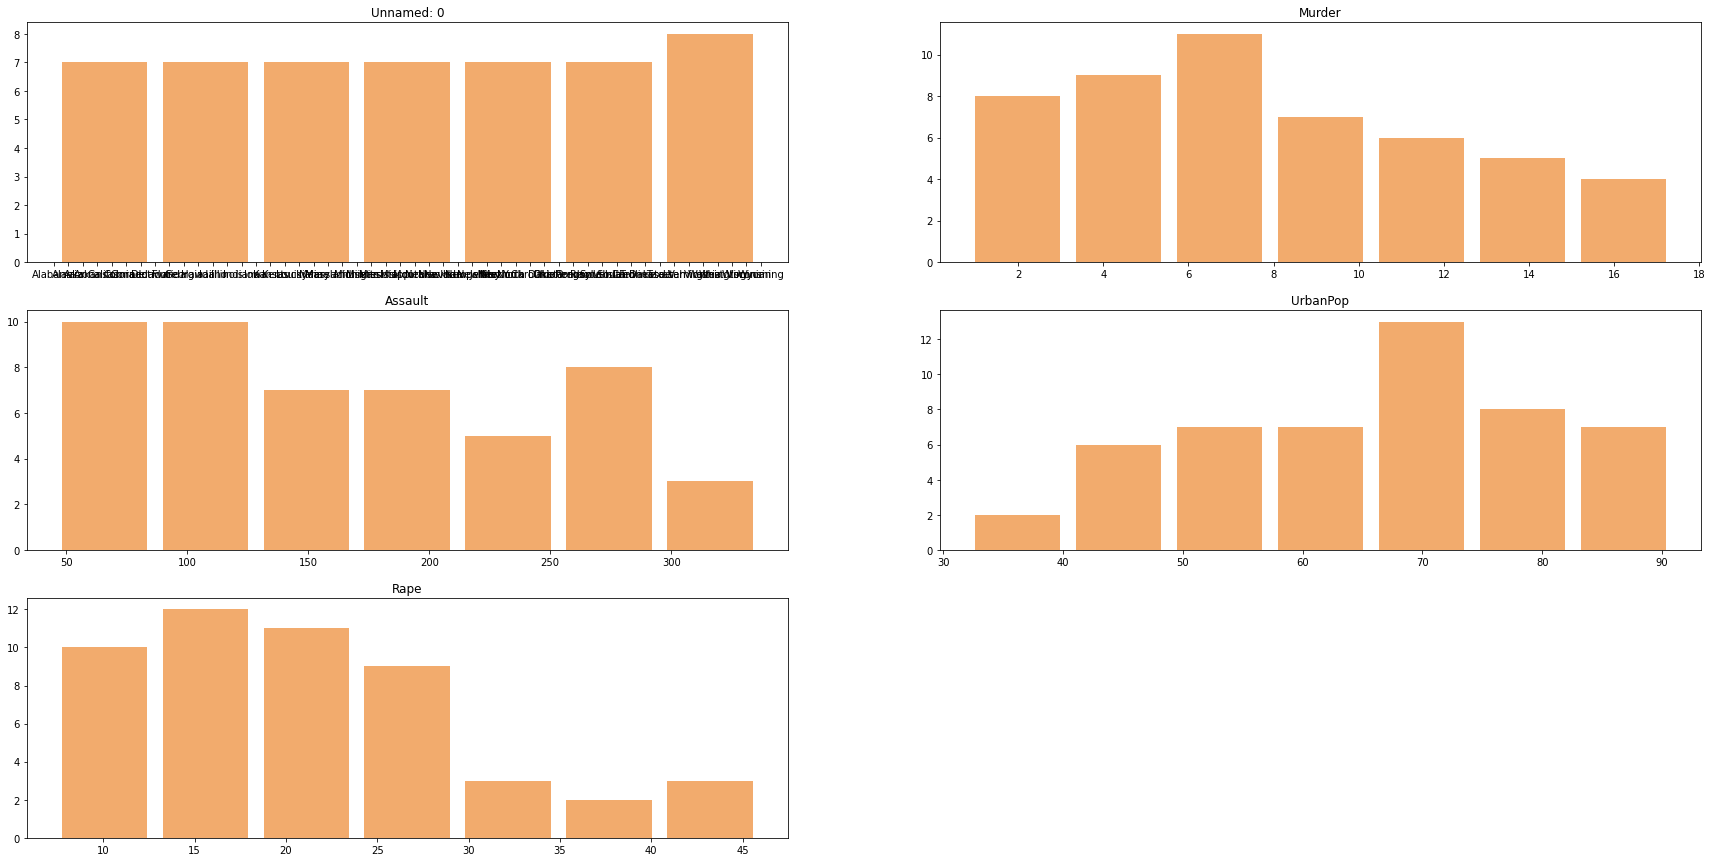

In [8]:
plot_distributions(violent_crime)

No se ven datos anomalos. De todas formas no podrian ser eliminados considerando el proposito del dataset. Paso a la construccion de los modelos.

Antes de seguir debo preparar ligeramente el dataset eliminando las etiquetas de Estados. Esto es solo para la implementacion del clustering. Una vez que se tengan los resultados se compararan con el listado de Estados.

In [9]:
estados=violent_crime.loc[:,'Unnamed: 0']
estadisticas=violent_crime.drop(['Unnamed: 0'],axis=1)

estados.head()
estadisticas.head()

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5
2,8.1,294,80,31.0
3,8.8,190,50,19.5
4,9.0,276,91,40.6


---
##K-MEANS

In [10]:
from sklearn.cluster import KMeans #Importo K-MEANS

A continuacion el codigo para determinar numero optimo de clusters segun coeficiente de silueta y visualizarlos segun pares de atributos del dataset. El siguiente codigo voy a convertirlo en una funcion.

El numero de clusters ideal segun coeficiente de silueta es:  2
[1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 0]


<Figure size 432x288 with 0 Axes>

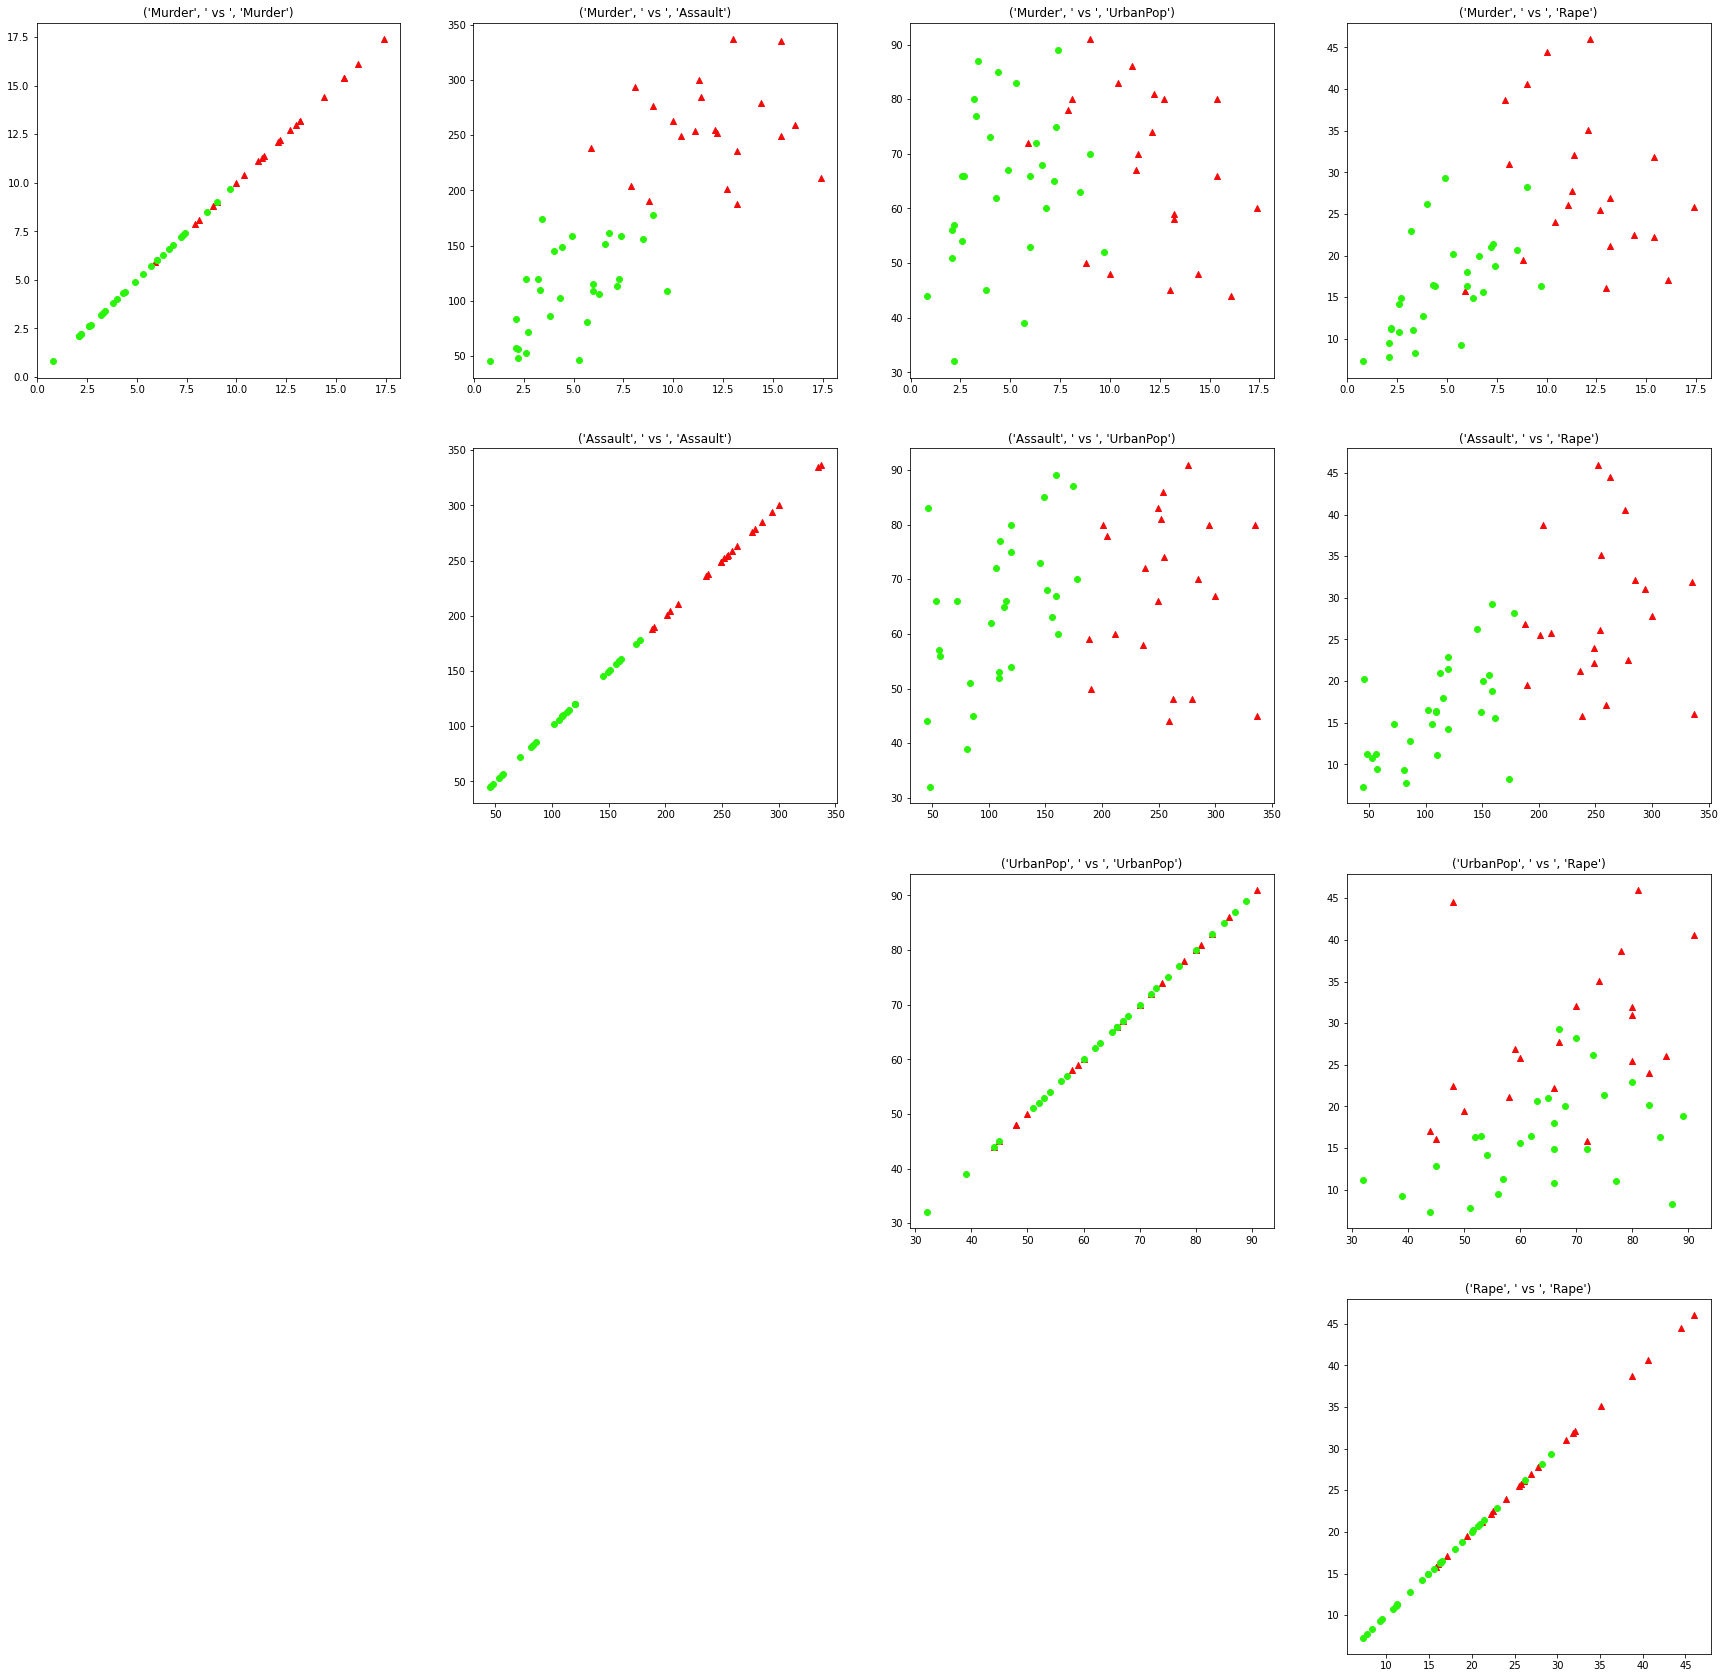

In [11]:
clusters_segun_silueta(estadisticas,KMeans(),2,10,1)


---
##MEAN SHIFT

In [12]:
from sklearn.cluster import MeanShift #Importo mean shift
cms = MeanShift() #(Cluster Mean Shift) 

In [13]:
#implemento el clustering a los dataframes, cada uno con prefijo segun channel, region o global

estadisticas_ms=cms.fit(estadisticas)

In [14]:
#evaluo el numero de clusters de cada uno
print('NUMERO DE CLUSTERS SEGUN MEAN SHIFT: ', np.max(np.unique(estadisticas_ms.labels_)))

NUMERO DE CLUSTERS SEGUN MEAN SHIFT:  2


<Figure size 432x288 with 0 Axes>

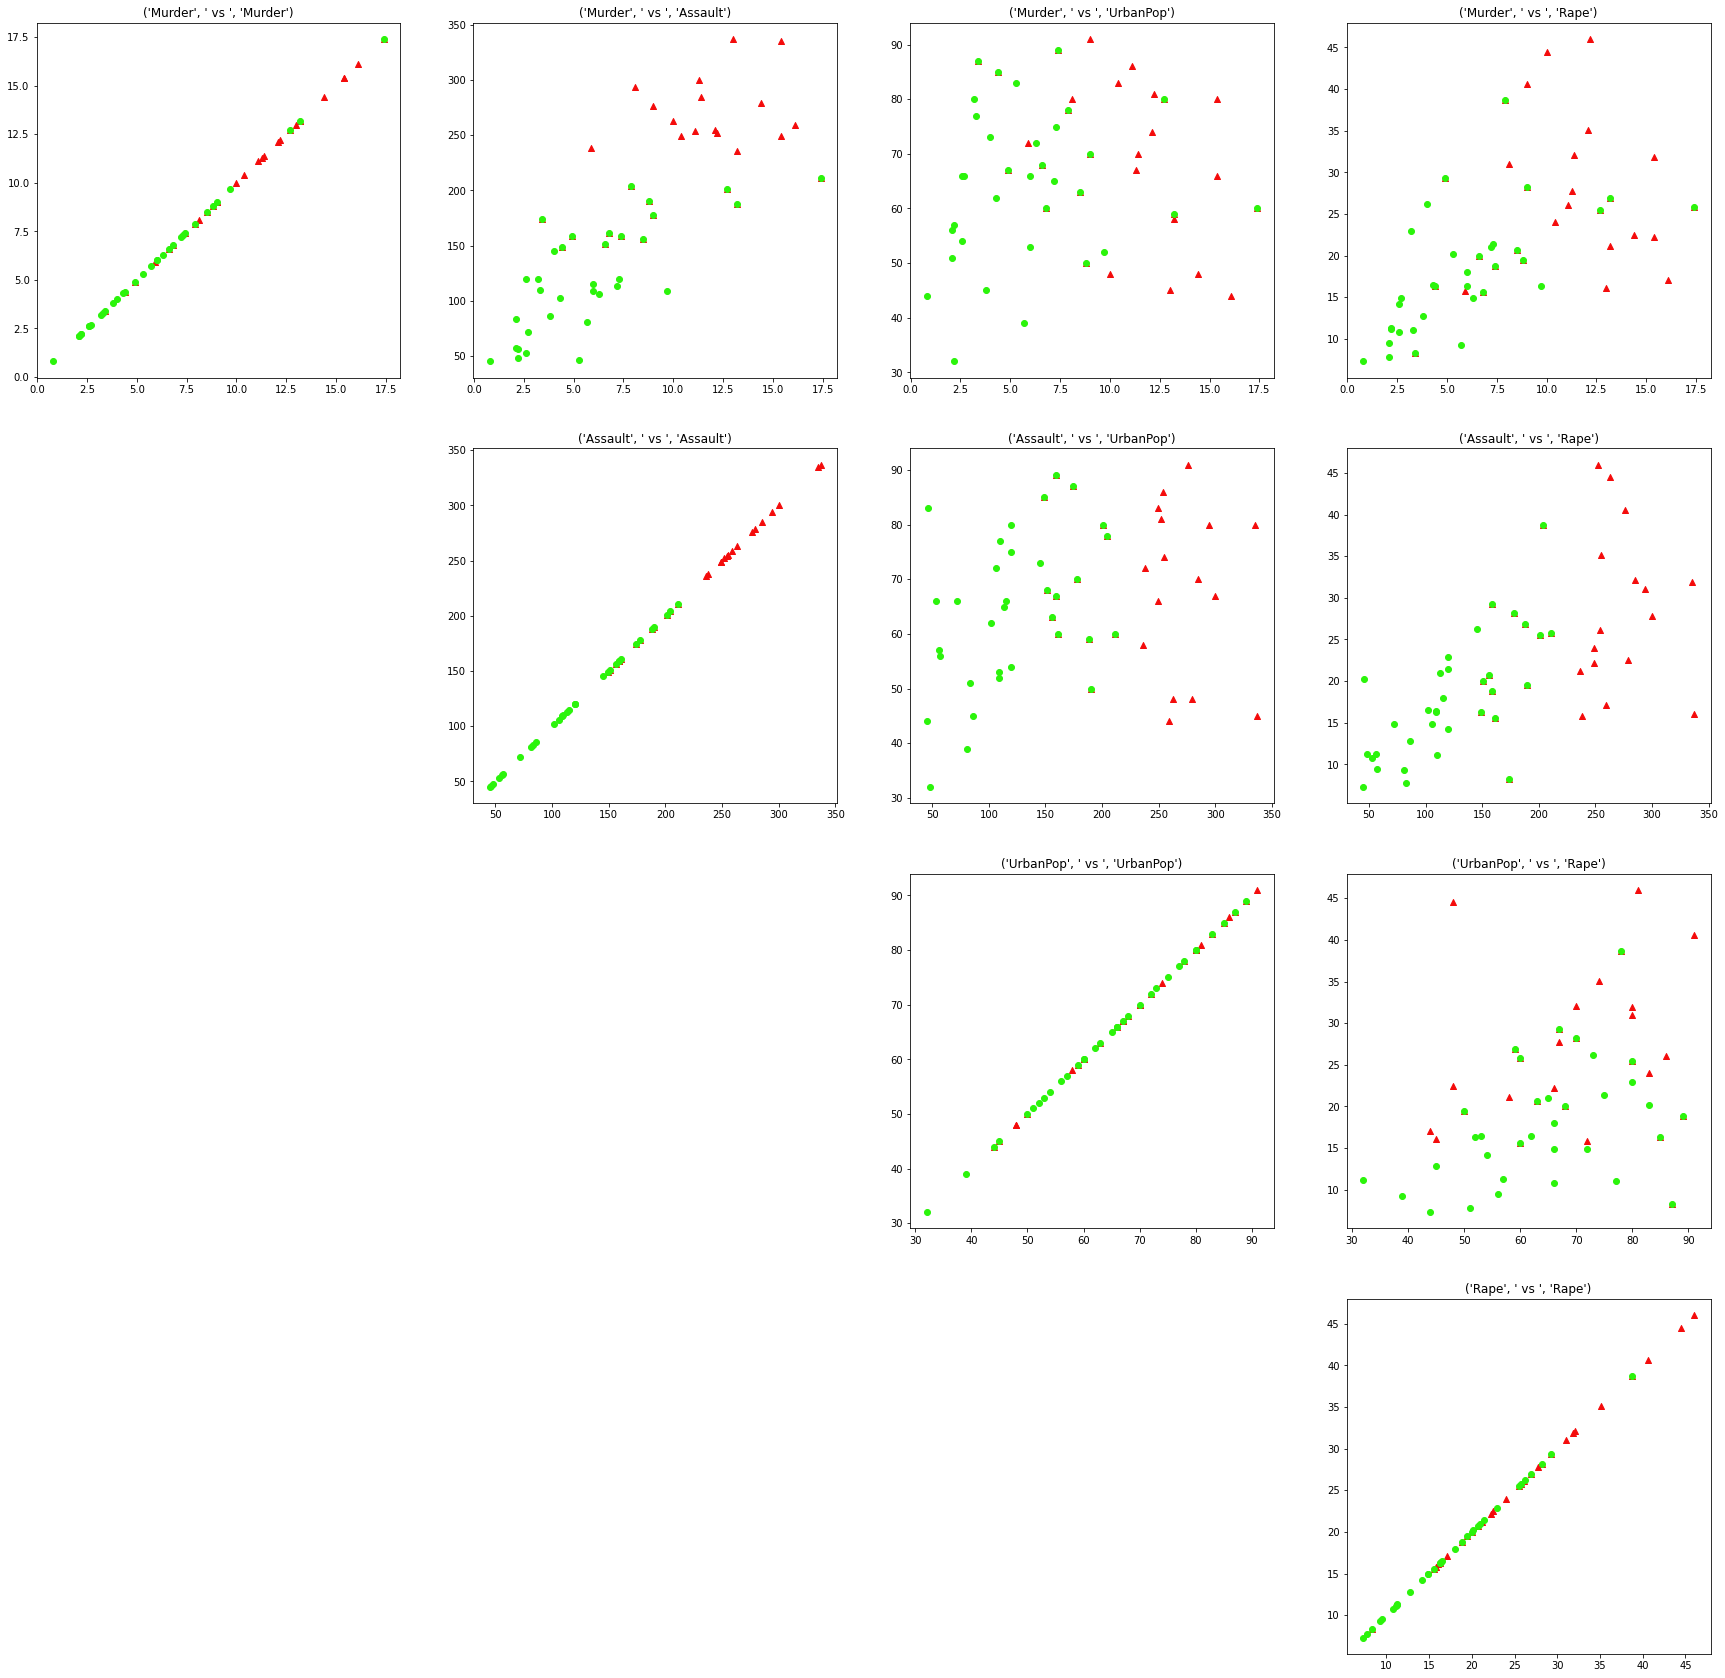

In [15]:
graficar_columnas_enfrentadas(estadisticas,estadisticas_ms.labels_)

##HIERARCHICAL CLUSTERING

In [16]:
from sklearn.cluster import AgglomerativeClustering

El numero de clusters ideal segun coeficiente de silueta es:  2
[1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0]


<Figure size 432x288 with 0 Axes>

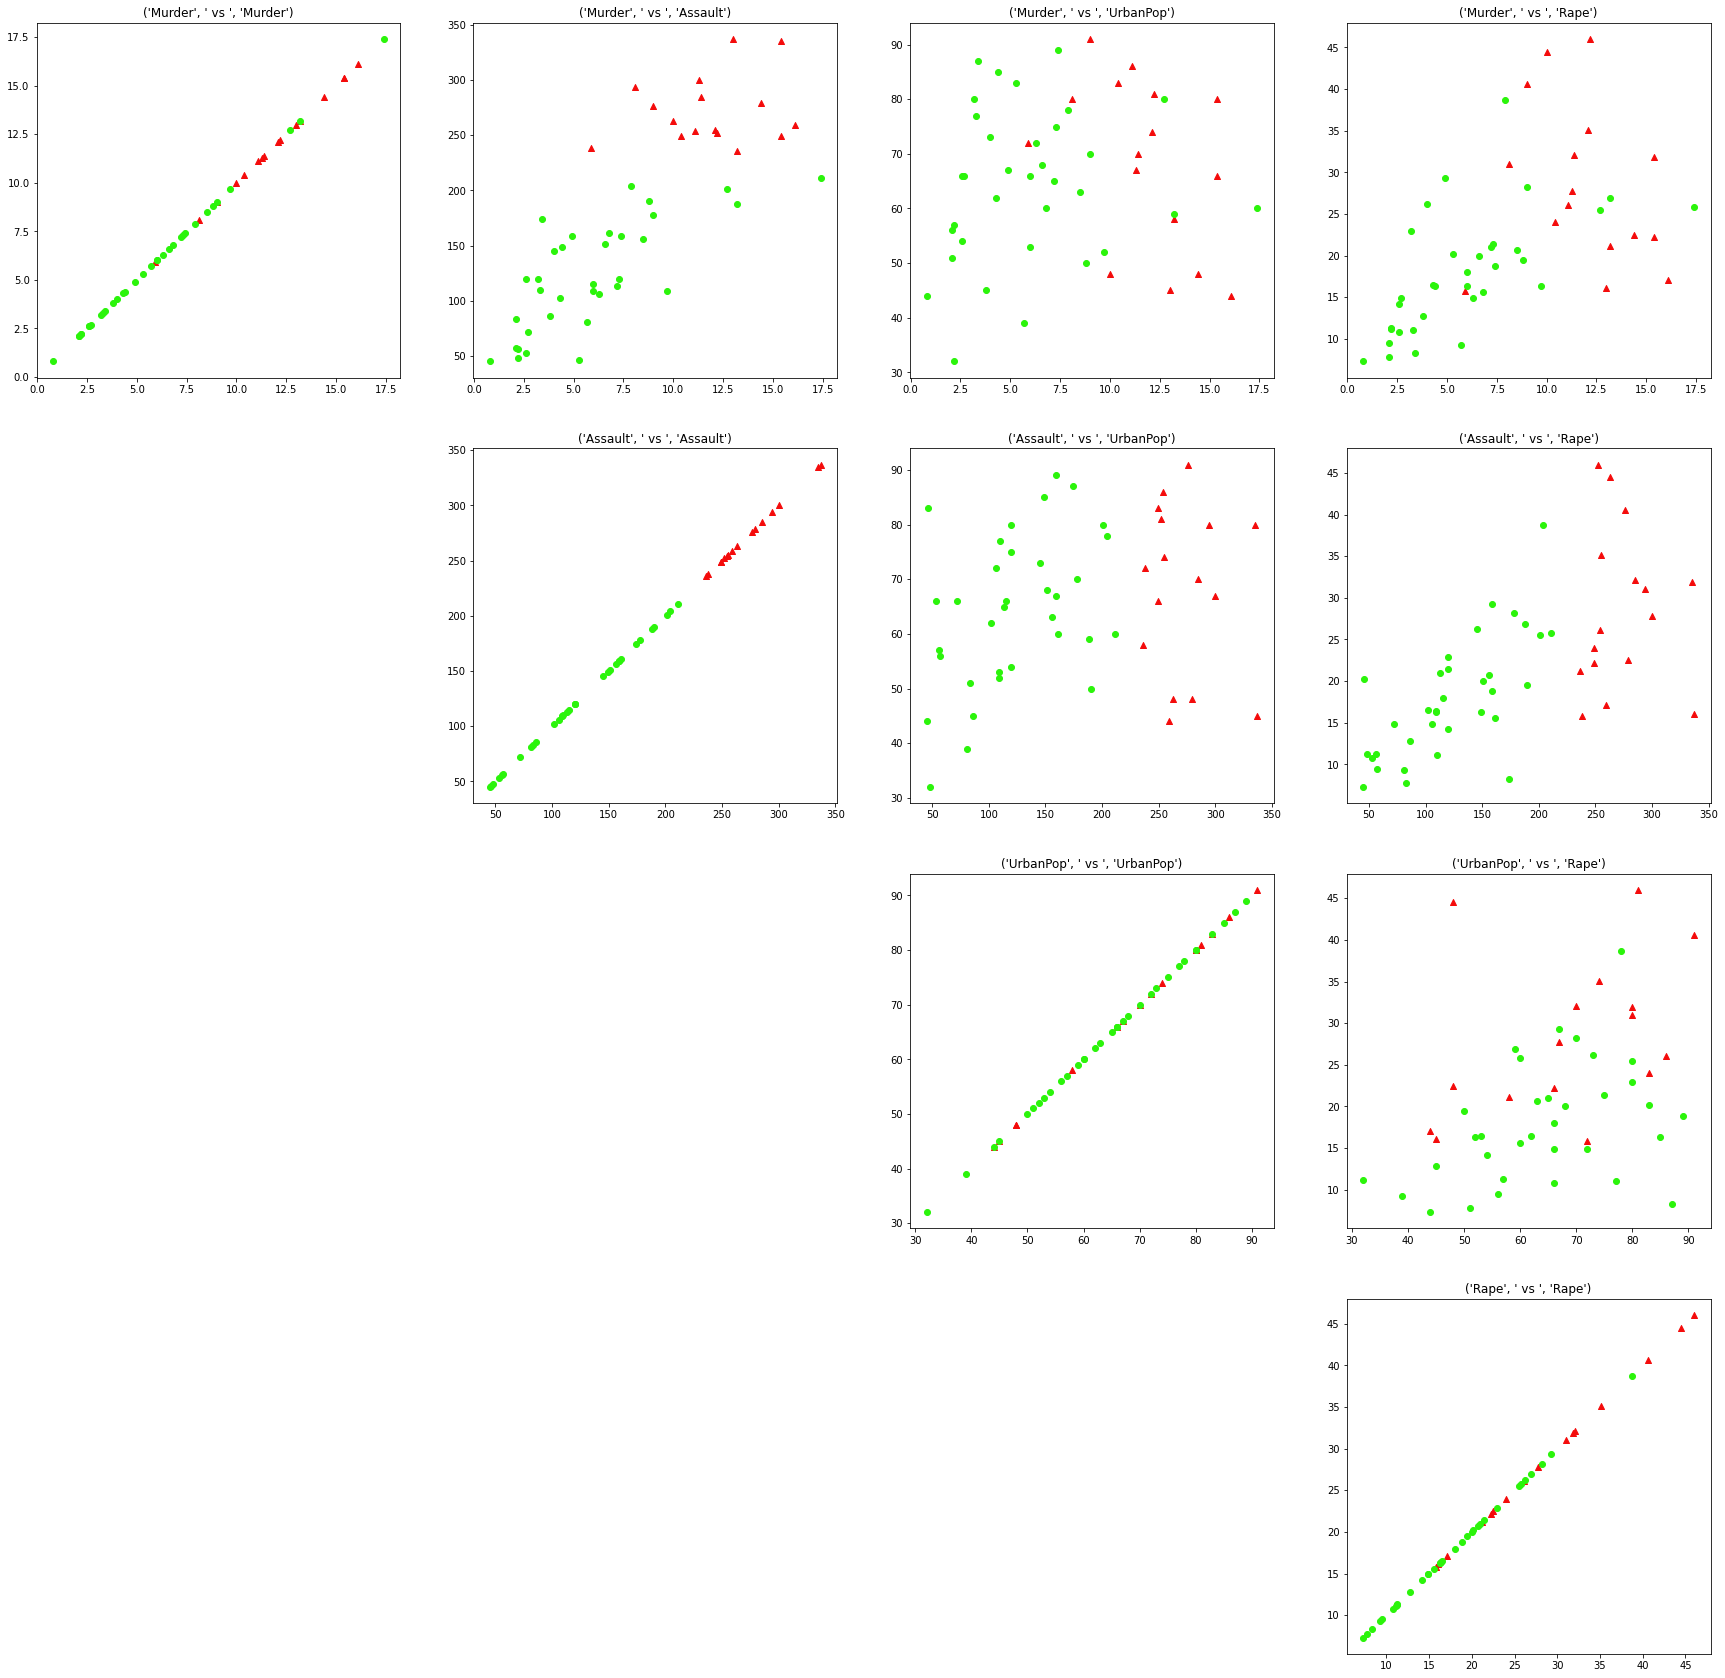

In [17]:
clusters_segun_silueta(estadisticas,AgglomerativeClustering(),2,10,1)

---
#***RESULTADOS Y ANÁLISIS***

Ignorare para las conclusiones la estadistica de "Urban Pop" ya que no termino de comprender a que porcentaje de poblacion se refiere.

Los resultados han sido similares en los tres metodos, lo cual es una buena señal. En particular debemos recordar que el metodo Mean Shift calcula los clusters de forma autonoma, por lo que no tenia porque converger a los mismos que encontre con el coeficiente de silueta para los casos de K-Means y clustering jerarquico. Por este motivo hablare en las conclusiones de los patrones en general. 

Para un analisis rapido podemos observar la diagonal de graficos, notando que los estados del cluster rojo suelen tener mas crimenes cada 100.000 habitantes que los del grupo verde. Esta idea se confirma al ver las relaciones del resto de los graficos, en el cual el grupo rojo se encuentra mas arriba en ambas escalas sin importar el tipo de crimen. Existe una cierta superposicion si vemos las graficas enfrentadas sobre la region que separa los dos clusters, lo cual es de esperarse y podria refinarse con algun otro metodo adicional. Como detallecito extra puedo ver que existe cierta corelacion entre los crimenes, aunque es un poco debil.

En resumen de todo lo anterior: los estados del cluster rojo tienden a tener una mayor tasa de crimenes general que los del cluster verde (si bien en algunas metricas pueden estar mejor que algunos verdes, pierden en el esto). Es decir: los estados rojos tienen mas crimenes que los verdes.

Como ultimo detalle puedo determinar facilmente cuales estados corresponden a cada grupo utilizando las etiquetas y las predicciones si quisiera poner nombre a los integrantes de cada grupo.

---
#Referencias

Foro discutiendo el analisis de clustering no supervisado:
https://stats.stackexchange.com/questions/21807/evaluation-measures-of-goodness-or-validity-of-clustering-without-having-truth

Evaluation Metrics for Unsupervised Learning Algorithms:
https://arxiv.org/pdf/1905.05667.pdf

Metodos de clustering de sklearn, aplicaciones y restricciones:
https://scikit-learn.org/stable/modules/clustering.html#clustering

3 metodos para determinar el numero de clusters optimo: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/#elbow-method


